# Project Inquiries:

1) Is the Earth’s temperature rising over time?

2) Does Earth’s temperature fluctuate in a predictable pattern?

3) Can we use readings of past Earth temperatures to predict future Earth temperatures?

4) Does taking the average temperature over land very in pattern, predictability, or variability from temperature taken over land and ocean?

In [1]:
# imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

import fbprophet

import wrangle
import explore
import modeling

import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


# Acquire

In [2]:
df = pd.read_csv('GlobalTemperatures.csv')
df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare

•	set data to date time <br>
•	sorted rows by date <br>
•	set date as index <br>
•	created separate dataframes for average land temperature and average land and ocean temperature <br>
•	converted temperature form both dataframes to farenhight <br>
•	removed data prior to ‘1753’ from the land only dataframe to remove nulls <br>
•	removed data prior to '1850' from the land and ocean dataframe to remove nulls <br>

In [3]:
df_land, df_ocean = wrangle.pre_split_prep(df)

### Split Data
•	~80% train <br>
•	~13% validate <br>
•	~7% test <br>
•	data seperated at the end of the nearest year

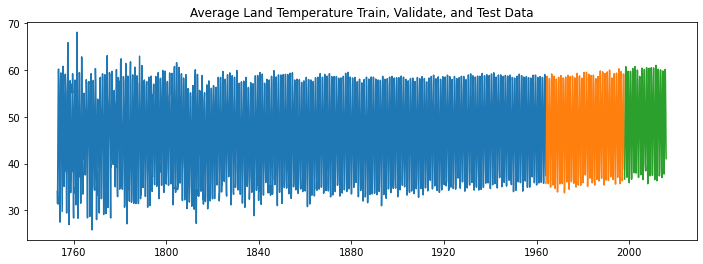

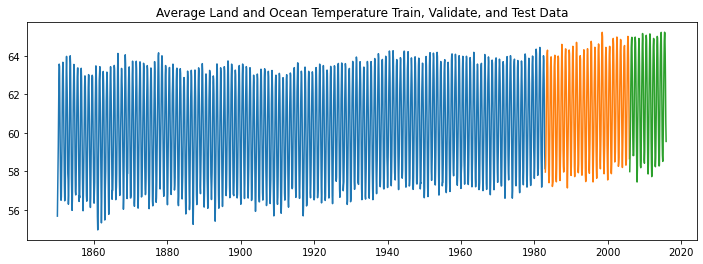

In [4]:
train_land, validate_land, test_land, train_ocean, validate_ocean, test_ocean = wrangle.tvt_split(df_land, df_ocean)

In [5]:
train_ocean

,LandAndOceanAverageTemperature
dt,
1850-01-01,55.666
1850-02-01,57.176
1850-03-01,58.086
1850-04-01,59.334
1850-05-01,61.014
...,...
1982-08-01,63.734
1982-09-01,62.708
1982-10-01,60.986


In [6]:
validate_ocean

,LandAndOceanAverageTemperature
dt,
1983-01-01,57.958
1983-02-01,58.338
1983-03-01,59.366
1983-04-01,60.936
1983-05-01,62.680
...,...
2005-08-01,64.750
2005-09-01,63.806
2005-10-01,62.050


In [7]:
test_ocean

,LandAndOceanAverageTemperature
dt,
2006-01-01,57.980
2006-02-01,58.870
2006-03-01,59.932
2006-04-01,61.458
2006-05-01,62.926
...,...
2015-08-01,65.178
2015-09-01,64.098
2015-10-01,62.580


# Explore

In [8]:
train_land.describe()

,LandAverageTemperature
count,2532.000000
mean,46.421765
std,8.835657
min,25.840000
25%,38.159000
50%,46.860000
75%,54.684500
max,68.042000


### Land Only - Observations

•	Mean: 46 <br>
•	Std: 9 <br>
•	Range: 26 - 68 = 42 <br>

### Explore plot of average land temperatures grouped by month, year, and decade

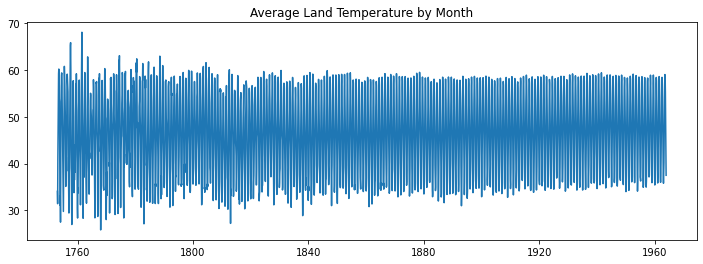

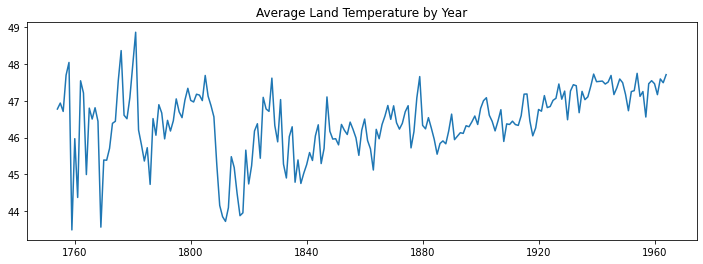

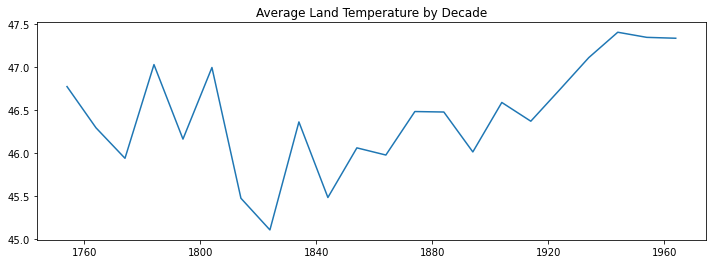

In [9]:
explore.plot_land_exploration(train_land)

### Land Only - Observations

•	The monthly average temperature shows a large variability in temperature towards the beginning of the data, which decreases over time (Possibly the result of innovations in temperature reading technology). <br>

•	The yearly average temperature shows a large variability in temperature towards the beginning of the data, which decreases over time (Possibly the result of innovations in temperature reading technology). <br>

•	It also shows warming trend beginning in the early 1800’s and continuing to the end of the training data. Over this time the yearly average temperature has risen about 3 degrees <br>

•	The by decade average temperature shows a warming trend beginning in the early 1800’s and continuing toward the end of the test data. Over this time the by decade average temperature has risen about 2 degrees <br>

•	Data not sectioned by full decades (first and last data point may be distorted as a result) <br>

### Explore plot of average land and ocean temperatures grouped by month, year, and decade

In [10]:
train_ocean.describe()

,LandAndOceanAverageTemperature
count,1596.000000
mean,60.196054
std,2.517954
min,54.950000
25%,57.828000
50%,60.318000
75%,62.582000
max,64.434000


### Land and Ocean - Observations

•	Mean: 60 <br>
•	Std: 3 <br>
•	Range: 64 - 55 = 42 <br>

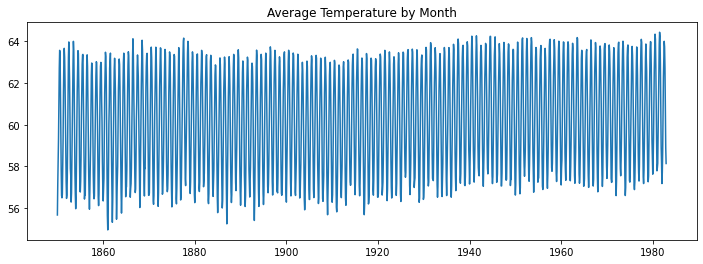

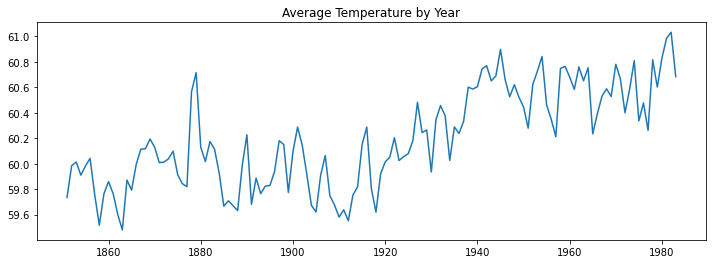

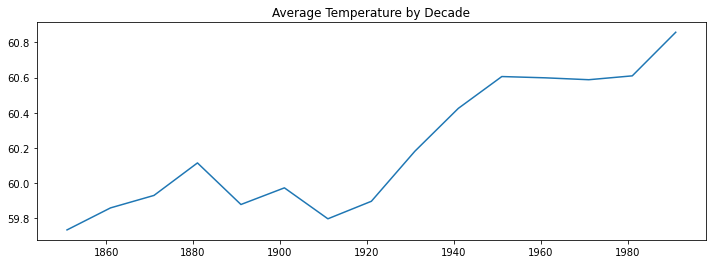

In [11]:
explore.plot_land_ocean_explore(train_ocean)

### Land and Ocean - Observations

•	The monthly average temperature shows a mostly consistent seasonality in average temperature <br>

•	The yearly average temperature shows a warming period from 1910-1940 during this time the by decade average temperature went up by about one degree. This was followed by a leveling off period in which the temperature maintained a fairly consistent fluctuation between 60.4 and 60.8 degrees. The temperature reaches its highest toward the end of the graph at about 61 degrees. <br>

•	The by decade average shows a warming trend of one degree across all of the training data.



### Compare plot of average land temperature and average land and ocean temperature

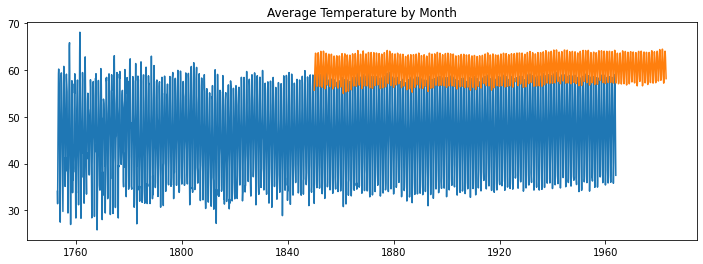

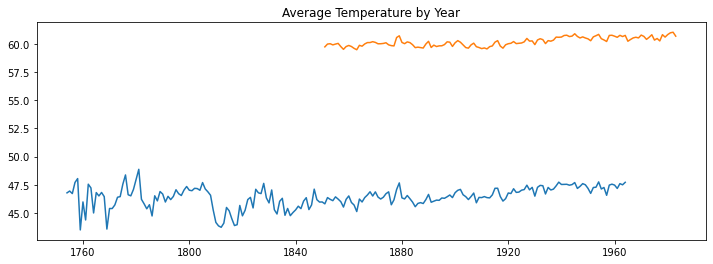

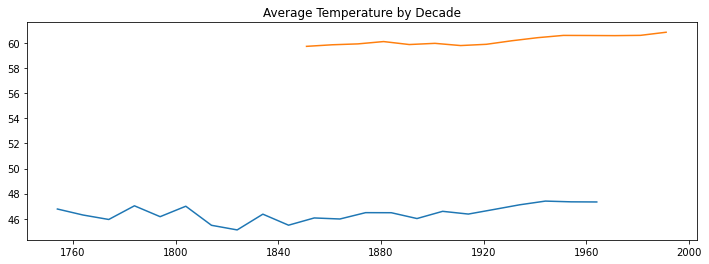

In [12]:
explore.compare_plot(train_land, train_ocean)

### Comparison Observations

•	land only temperature averages cover a much larger range than land and ocean temperature averages <br>

•	They also have higher amount of variability, particularly towards the beginning of the data. The variability smooths out over time and is dramatically lessoned by the time land and ocean temperature averages begin appearing in the data <br>

•	Does less reliable temperature measurements account for the variation in average temperature from 1750 to about the 1840’s? <br>


# Modeling

### Plot a graph of the following for land only temperature averages:
•	last observed value <br>
•	simple average <br>
•	moving average: 1 month, 1 year, 1 decade <br>

### Use the best result as the baseline for modeling

Last Observed Value -- RMSE: 13.0957


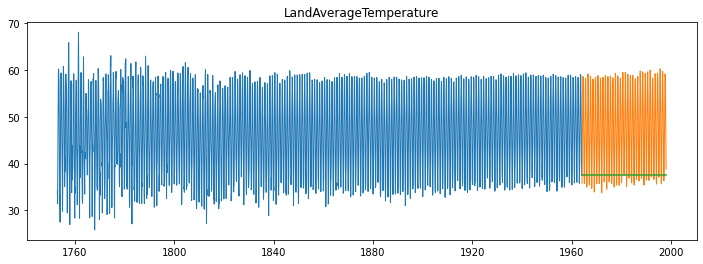

Simple Average -- RMSE: 8.3818


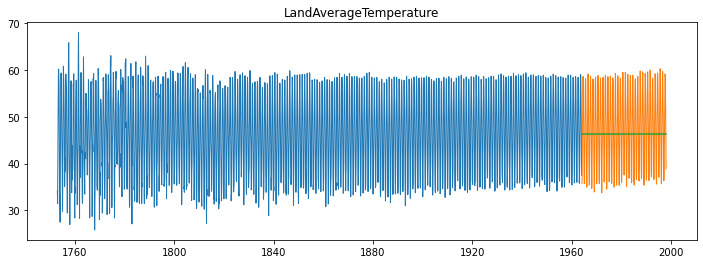

One Month Moving Average  -- RMSE: 13.0957


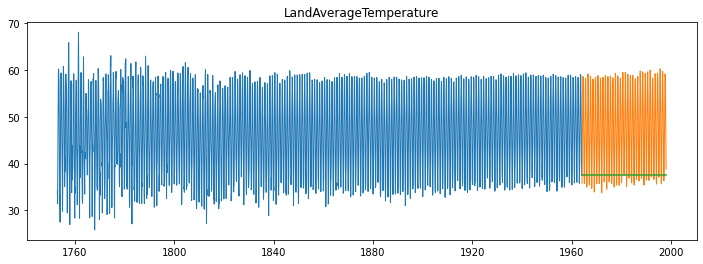

One Year Moving Average  -- RMSE: 8.294


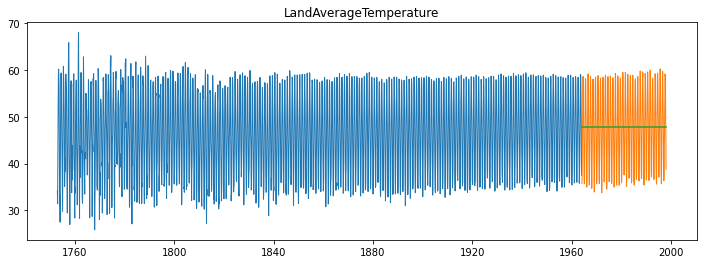

One Decade Moving Average  -- RMSE: 8.2989


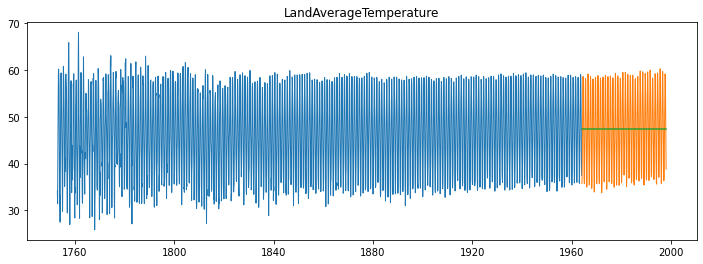

In [13]:
# create comparison dataframes to append prediction results to
eval_df_land = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
df_baseline_land = modeling.get_baseline(train_land, validate_land, 'LandAverageTemperature', eval_df_land)

In [14]:
df_baseline_land

,model_type,target_var,rmse
0,Last Observed Value,LandAverageTemperature,13.0957
1,Simple Average,LandAverageTemperature,8.3818
2,One Month Moving Average,LandAverageTemperature,13.0957
3,One Year Moving Average,LandAverageTemperature,8.2940
4,One Decade Moving Average,LandAverageTemperature,8.2989


### The best baseline for land only average temperatures is one year moving average with an rmse of 8.2940

### Plot a graph of the following for land only temperature averages:
•	last observed value <br>
•	simple average <br>
•	moving average: 1 month, 1 year, 1 decade <br>

### Use the best result as the baseline for modeling

Last Observed Value -- RMSE: 3.9103


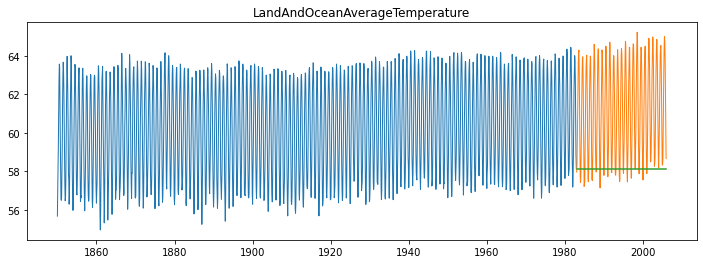

Simple Average -- RMSE: 2.631


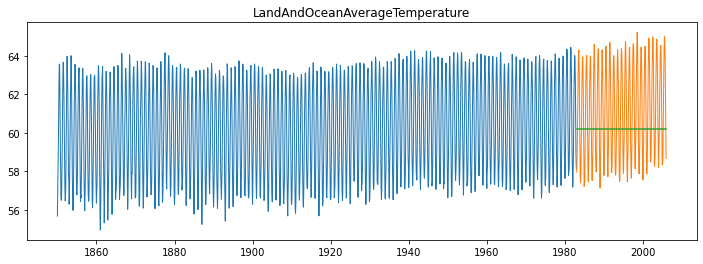

One Month Moving Average  -- RMSE: 3.9103


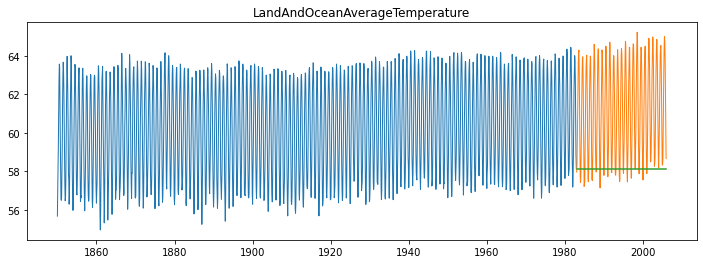

One Year Moving Average  -- RMSE: 2.4867


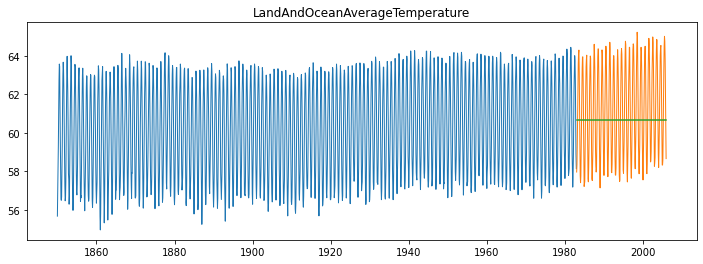

One Decade Moving Average  -- RMSE: 2.4869


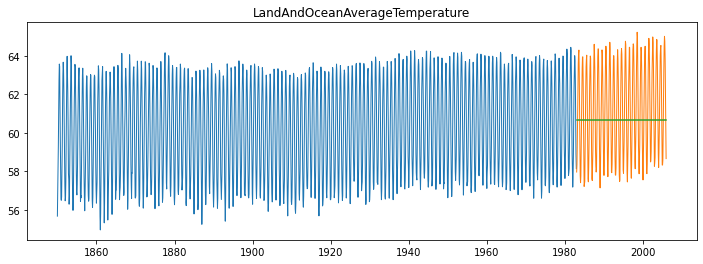

In [15]:
eval_df_ocean = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
df_baseline_ocean = modeling.get_baseline(train_ocean, validate_ocean, 'LandAndOceanAverageTemperature', eval_df_ocean)

In [16]:
df_baseline_ocean

,model_type,target_var,rmse
0,Last Observed Value,LandAndOceanAverageTemperature,3.9103
1,Simple Average,LandAndOceanAverageTemperature,2.6310
2,One Month Moving Average,LandAndOceanAverageTemperature,3.9103
3,One Year Moving Average,LandAndOceanAverageTemperature,2.4867
4,One Decade Moving Average,LandAndOceanAverageTemperature,2.4869


### The best baseline for land and ocean average temperatures is one year moving average with an rmse of 2.867

### Make predictions using Holt's Linear Trend
The initial presumptions when using Holt’s linier trend are that the data has a trend and that the data is not seasonal. As the data used in this study is seasonal, I expect to get dubious results from trying to model this data using this method. However, as this project is a learning activity, I have decided to give it a go anyway, as it should provide an excellent case study in why using Holt’s linier trend in this way is ill advised.

Holt's Linear Trend -- RMSE: 15.7201


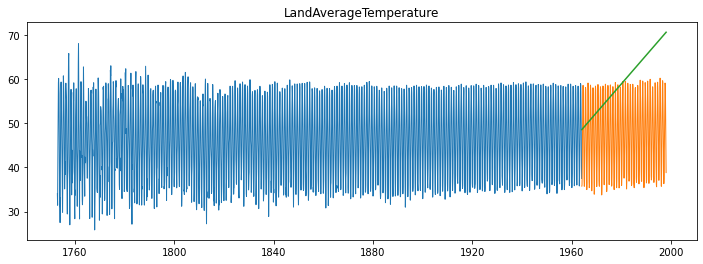

Holt's Linear Trend -- RMSE: 3.1956


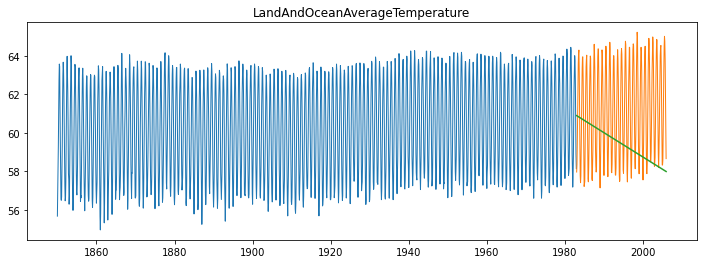

In [17]:
df_holt_land = modeling.holt(train_land, validate_land, "LandAverageTemperature", eval_df_land)
df_holt_ocean =modeling.holt(train_ocean, validate_ocean, "LandAndOceanAverageTemperature", eval_df_ocean)

As predicted Holt’s Linier trend accounted for a trend but not the seasonality of the data. This eventually results in predictions that are outside the range values being observed and only become more extreme the further out in time they are plotted. 

### Make predictions using the Holt-Winter method
The Holt Winter method uses exponential smoothing to account for both the trend and seasonality of the data. I expect better results from this model 

Holt Winter -- RMSE: 0.7391


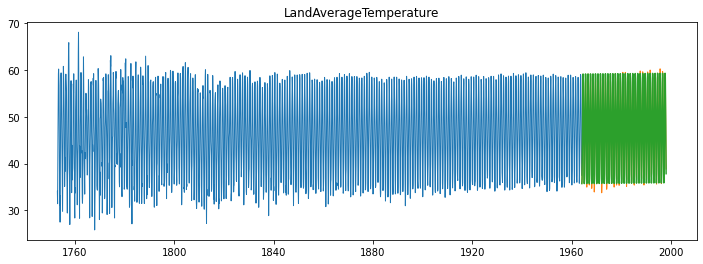

Holt Winter -- RMSE: 0.3875


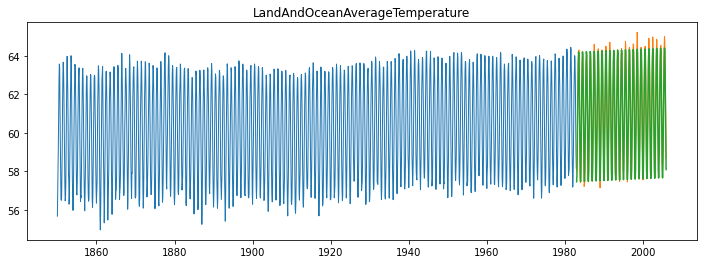

In [18]:
holt_winter_land = modeling.holt_winter(train_land, validate_land, "LandAverageTemperature", eval_df_land)
holt_winter_ocean = modeling.holt_winter(train_ocean, validate_ocean, "LandAndOceanAverageTemperature", eval_df_ocean)

### Both models preformed significantly better than baseline

Land only average temperature had an rmse of 0.7391 <br>
Land and ocean average temperature had an rmse of 0.3875

### Make predictions using Prophet

In [32]:
train_land_prophet = pd.DataFrame({'ds': '1', 'y' : '1'}, Index = None)
train_land_prophet

TypeError: __init__() got an unexpected keyword argument 'Index'

### Make Predictions using previous cycle

Predict Next Cycle -- RMSE: 0.6216


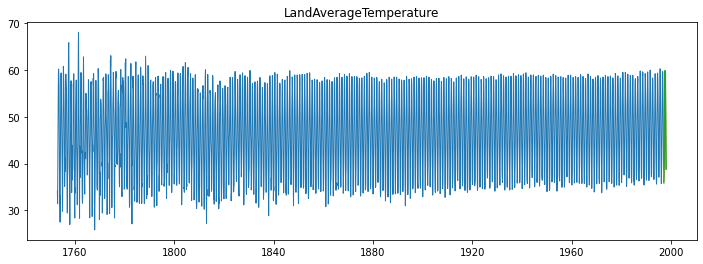

In [19]:
eval_df_land = modeling.next_cycle(df_land[:'1996'], df_land['1996'], df_land['1997'], 'LandAverageTemperature', eval_df_land)

Predict Next Cycle -- RMSE: 0.4775


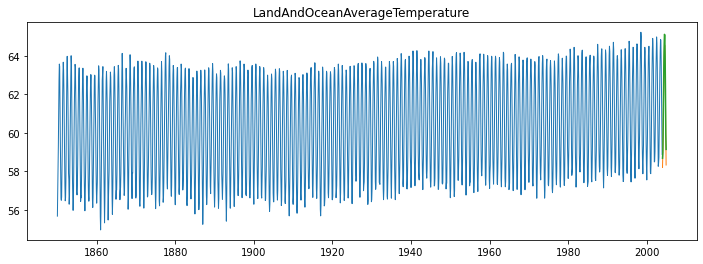

In [20]:
eval_df_ocean = modeling.next_cycle(df_ocean[:'2003'], df_ocean['2003'], df_ocean['2004'], 'LandAndOceanAverageTemperature', eval_df_ocean)

In [25]:
train_land.rename({"dt":"ds","LandAverageTemperature":"y"})

,LandAverageTemperature
dt,
1753-01-01,34.078
1753-02-01,31.430
1753-03-01,40.848
1753-04-01,46.544
1753-05-01,54.372
...,...
1963-08-01,58.618
1963-09-01,55.110
1963-10-01,49.886
